Instalace potřebných modulů: ipython, numpy, pandas, sklearn

In [1]:
!pip install ipython numpy pandas scikit-learn matplotlib

Načtení potřebných modulů

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from IPython.display import display
import matplotlib.pyplot as plt

Načtení a zpracování dat

In [3]:
# Načte data ze soubor
try:
    # Nejdříve zkusí excel soubor
    DATA = pd.read_excel("data.xlsx")
except:
    # Poté zkusí csv soubor
    # Pokud hlásí chybu, je možné nastavit vlastní:
    # > delimiter ... oddělovač dat (čárka, středník)
    # > decimal ... oddělovač desetinných míst (čírka, tečka)
    DATA = pd.read_csv("data.csv", delimiter=",", decimal=",")
display(DATA)
# Odstraní první sloupeček
data = DATA.drop(DATA.columns[0], axis=1, inplace=False)
# Získá indexy řídků, kde chybí číslo v posledním sloupečku
indexy_pro_predikci = data.index[data[data.columns[-1]].isnull().values].tolist()
# Získá řádky, které se mohou použít pro regresi
data_pro_predikci = data.loc[indexy_pro_predikci].drop(data.columns[-1], axis=1, inplace=False)
data = data.loc[data.index.difference(indexy_pro_predikci)]
# Převedení dat do číselných polí
data_numbers = data.to_numpy()
vstup_pro_regresi = data_numbers[:,:-1]
vystup_pro_regresi = data_numbers[:,-1]
vstup_pro_predikci = data_pro_predikci.to_numpy()

,nazev,hmotnost,pocet,vzdalenost,nafta,cena
0,0,538.636779,6,39.876092,44.652960,13916.0
1,1,900.114094,6,60.887474,47.199178,22201.0
2,2,538.777142,10,39.682076,41.864674,13943.0
3,3,464.390384,19,85.504486,42.351257,14838.0
4,4,590.878004,7,62.967277,31.104840,16098.0
...,...,...,...,...,...,...
97,97,323.503176,10,68.567087,44.296663,11087.0
98,98,648.336383,16,67.696253,39.367986,17590.0
99,99,118.015540,20,58.409993,44.476787,6570.0
100,predikce 1,120.000000,22,60.000000,49.000000,NaN


Vytvoření predikčního modelu pomocí lineární regrese

https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#linear-model-from-regression-to-sparsity

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [9]:
regrese = linear_model.LinearRegression()
regrese.fit(vstup_pro_regresi, vystup_pro_regresi)

# Výpis parametrů modelu
print("Lineární koeficienty:", [*regrese.coef_, regrese.intercept_])
print("Počet vstupních sloupců:", (regrese.rank_, regrese.n_features_in_))
print(
    "Průměrná chyba R2:",
    np.mean((regrese.predict(vstup_pro_regresi) - vystup_pro_regresi)**2),
    "(menší = lepší)"
)
print(
    "Skóre modelu:",
    regrese.score(vstup_pro_regresi, vystup_pro_regresi),
    "(lze predikovat? 0 = NE, 1 = ANO)"
)

Lineární koeficienty: [20.000050162684794, 10.009345819654634, 49.997336758032574, 2.003300495412073, 999.8718217748738]
Počet vstupních sloupců: (4, 4)
Průměrná chyba R2: 0.062082095638675755 (menší = lepší)
Skóre modelu: 0.9999999974437649 (lze predikovat? 0 = NE, 1 = ANO)


Predikce

In [5]:
vysledek_predikce = regrese.predict(vstup_pro_predikci)

Uložení predikovaných dat

In [6]:
DATA.loc[indexy_pro_predikci, DATA.columns[-1]] = vysledek_predikce
display(DATA)
DATA.to_excel("data_new.xlsx")

,nazev,hmotnost,pocet,vzdalenost,nafta,cena
0,0,538.636779,6,39.876092,44.652960,13916.000000
1,1,900.114094,6,60.887474,47.199178,22201.000000
2,2,538.777142,10,39.682076,41.864674,13943.000000
3,3,464.390384,19,85.504486,42.351257,14838.000000
4,4,590.878004,7,62.967277,31.104840,16098.000000
...,...,...,...,...,...,...
97,97,323.503176,10,68.567087,44.296663,11087.000000
98,98,648.336383,16,67.696253,39.367986,17590.000000
99,99,118.015540,20,58.409993,44.476787,6570.000000
100,predikce 1,120.000000,22,60.000000,49.000000,6718.085379


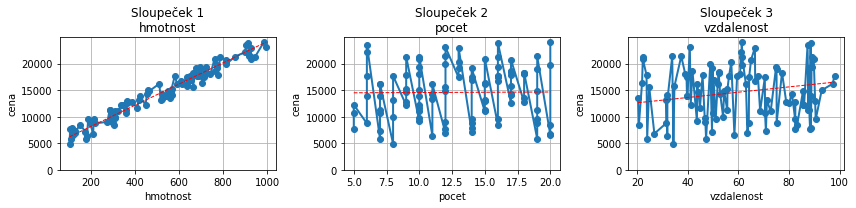

In [7]:
# Určí počet sloupců a řádků
N = vstup_pro_regresi.shape[1]
nx = 3
ny = int(N/nx + 0.5)
# Vytvoří podgrafy
fig, axes = plt.subplots(ncols=nx, nrows=ny, figsize=(4*nx, 3*ny))
# Projde všechny podgrafy a naplní je daty
for i, ax in zip(range(N), axes.flat):
    # Seřadí data
    serazene_data = zip(*sorted(zip(vstup_pro_regresi[:,i], vystup_pro_regresi)))
    # Vytvoří graf ze vstupních dat
    x = next(serazene_data)
    y = next(serazene_data)
    ax.plot(x, y, "-o", linewidth=2)
    ax.set_title(f"Sloupeček {i+1}\n{data.columns[i]}")
    ax.set_ylim(bottom=0)
    ax.set_xlabel(data.columns[i])
    ax.set_ylabel(data.columns[-1])
    ax.grid(True)
    # Vytvoří přibližnou reprezentaci lineárního modelu
    q = regrese.coef_[i]
    mx = np.mean(x)
    my = np.mean(y)
    k = my - q*mx
    y2 = [q*xi + k for xi in x]
    ax.plot(x, y2, "r--", linewidth=1)
# Vymaže prázdné grafy
for i in range(N, len(axes.flat)):
    axes.flat[i].remove()
# Zobrazí vše
plt.tight_layout()
plt.show()